# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import math

Load feature names.

In [3]:
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


In [11]:
print train_data[:5]
print train_labels[:5]

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.
   0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
   0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.
   0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
   0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.

(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

1: 0.164043312793
2: 0.297278101488
3: 0.399012666709
4: 0.469646231059
5: 0.508312694566
6: 0.545120737641
7: 0.576403128668
8: 0.603740502195
9: 0.629905406884
10: 0.652214832563
11: 0.672696562099
12: 0.69137986869
13: 0.70872408902
14: 0.725567695477
15: 0.740755883424
16: 0.755842067705
17: 0.770133402741
18: 0.784253529053
19: 0.797503976447
20: 0.808967765956
21: 0.819678424424
22: 0.830335890867
23: 0.840745562597
24: 0.850682547861
25: 0.859763246507
26: 0.86845650881
27: 0.876412676165
28: 0.884170921684
29: 0.891546618434
30: 0.898549378056
31: 0.904961709568
32: 0.911106843895
33: 0.916830293864
34: 0.922166582936
35: 0.927425943815
36: 0.932452686012
37: 0.937443104213
38: 0.942002524378
39: 0.94653036284
40: 0.950928240603
41: 0.955123130561
42: 0.959100152019
43: 0.96280057719
44: 0.966395861489
45: 0.969777101013
46: 0.972766968756
47: 0.975487279883
48: 0.977844339442
49: 0.980058332909


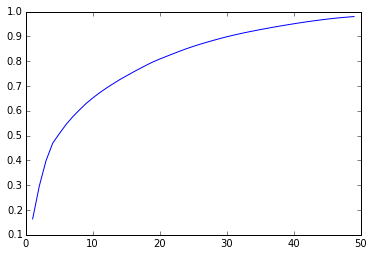

In [5]:
#def P1():
### STUDENT START ###
explain_level = []

for i in range(1,50):
    pca_p1 = PCA(n_components = i)
    pca_p1.fit(train_data, train_labels)
    explain_level.append(sum(pca_p1.explained_variance_ratio_))
    print str(i) + ": " + str(sum(pca_p1.explained_variance_ratio_))
    
plt.plot(range(1,50), explain_level)
plt.show()

### STUDENT END ###

#P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

(7000, 2)
[[ 1.05434454 -0.89426308]
 [ 1.44383045 -0.08008516]
 [ 1.54310134 -0.28842409]
 ..., 
 [ 0.84782643 -0.5247949 ]
 [ 1.07204581  0.23034774]
 [ 0.47873986 -0.9996519 ]]
[ 0.16404331  0.13323479]
[[  3.29929942e-02   6.72137537e-05   4.21332937e-02  -3.55472180e-03
   -7.31074041e-02   1.46862424e-03   6.01322198e-02   2.85038529e-04
   -3.58473885e-02  -2.45698699e-02  -2.39168394e-02   6.84430421e-03
   -1.26674523e-03   2.17271385e-02  -4.31746379e-04   5.14281010e-03
   -4.57951777e-04  -5.83437417e-02   6.51607601e-02  -1.44579884e-02
    2.84134667e-01  -2.84134667e-01   4.16059513e-02   4.16059513e-02
    6.58085891e-03  -6.80018063e-02  -1.68452417e-01  -1.91252027e-03
    2.00351525e-01   1.94372805e-02  -7.12148230e-02   6.26353689e-04
    0.00000000e+00  -6.26353689e-04   0.00000000e+00  -4.12686017e-02
    4.12686017e-02   0.00000000e+00   1.81410114e-01  -1.81410114e-01
    2.76784728e-02   7.91371968e-02  -2.13643073e-01  -2.59130040e-02
   -1.74040147e-02   1.8

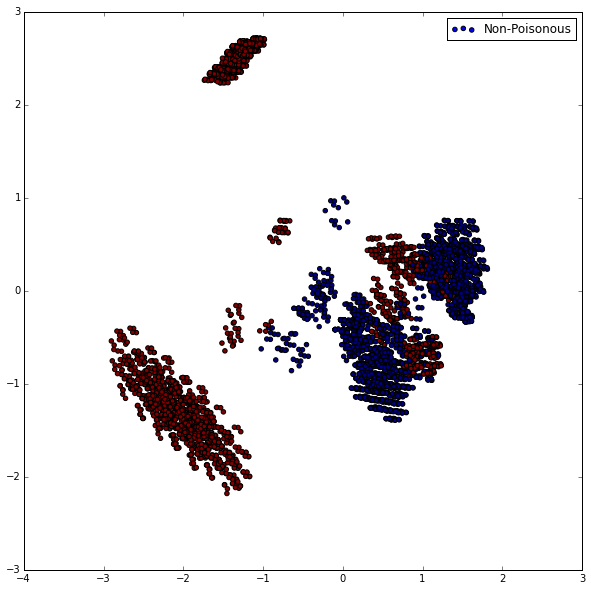

In [6]:
#def P2():
### STUDENT START ###

pca_p2 = PCA(n_components = 2).fit(train_data, train_labels)
data_reduced = pca_p2.transform(train_data)

print data_reduced.shape
print data_reduced
print pca_p2.explained_variance_ratio_
print pca_p2.components_

x_reduced = [x[0] for x in data_reduced]
y_reduced = [x[1] for x in data_reduced]

plt.figure(figsize=(10,10))
plt.scatter(x_reduced, y_reduced, c = train_labels, label = "Non-Poisonous")
plt.legend(loc = "best")
plt.show()

### STUDENT END ###

#P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

0: [ -4.92996913e-15   2.31766987e-16], 2.98858814531
1: [-1.67643875  0.31610217], 2.50555878321
2: [-1.9891398  -1.29271053], 1.58731827297
3: [ 0.45688491 -0.66581823], 1.8665578842
4: [ 0.05418471 -0.17762706], 1.34987987381
5: [-2.27721017 -1.05358311], 1.32682114177
6: [ 1.15259303  0.3605581 ], 0.82339021766
7: [ 1.46605176  0.05241834], 0.62335752796
8: [ 0.4818997  -0.97337329], 0.471431053036
9: [ 0.26389493 -0.39000401], 0.496918558364
10: [ 1.44187765 -0.03748264], 0.358133157355
11: [-1.58914942 -1.70609839], 0.51039714769
12: [-1.19480149  2.61085944], 0.230461033966
13: [ 0.40586183 -0.76692963], 0.408239194467
14: [-0.55341719  0.64475504], 0.678190198809
15: [-0.86576806 -0.4361454 ], 0.662607525168


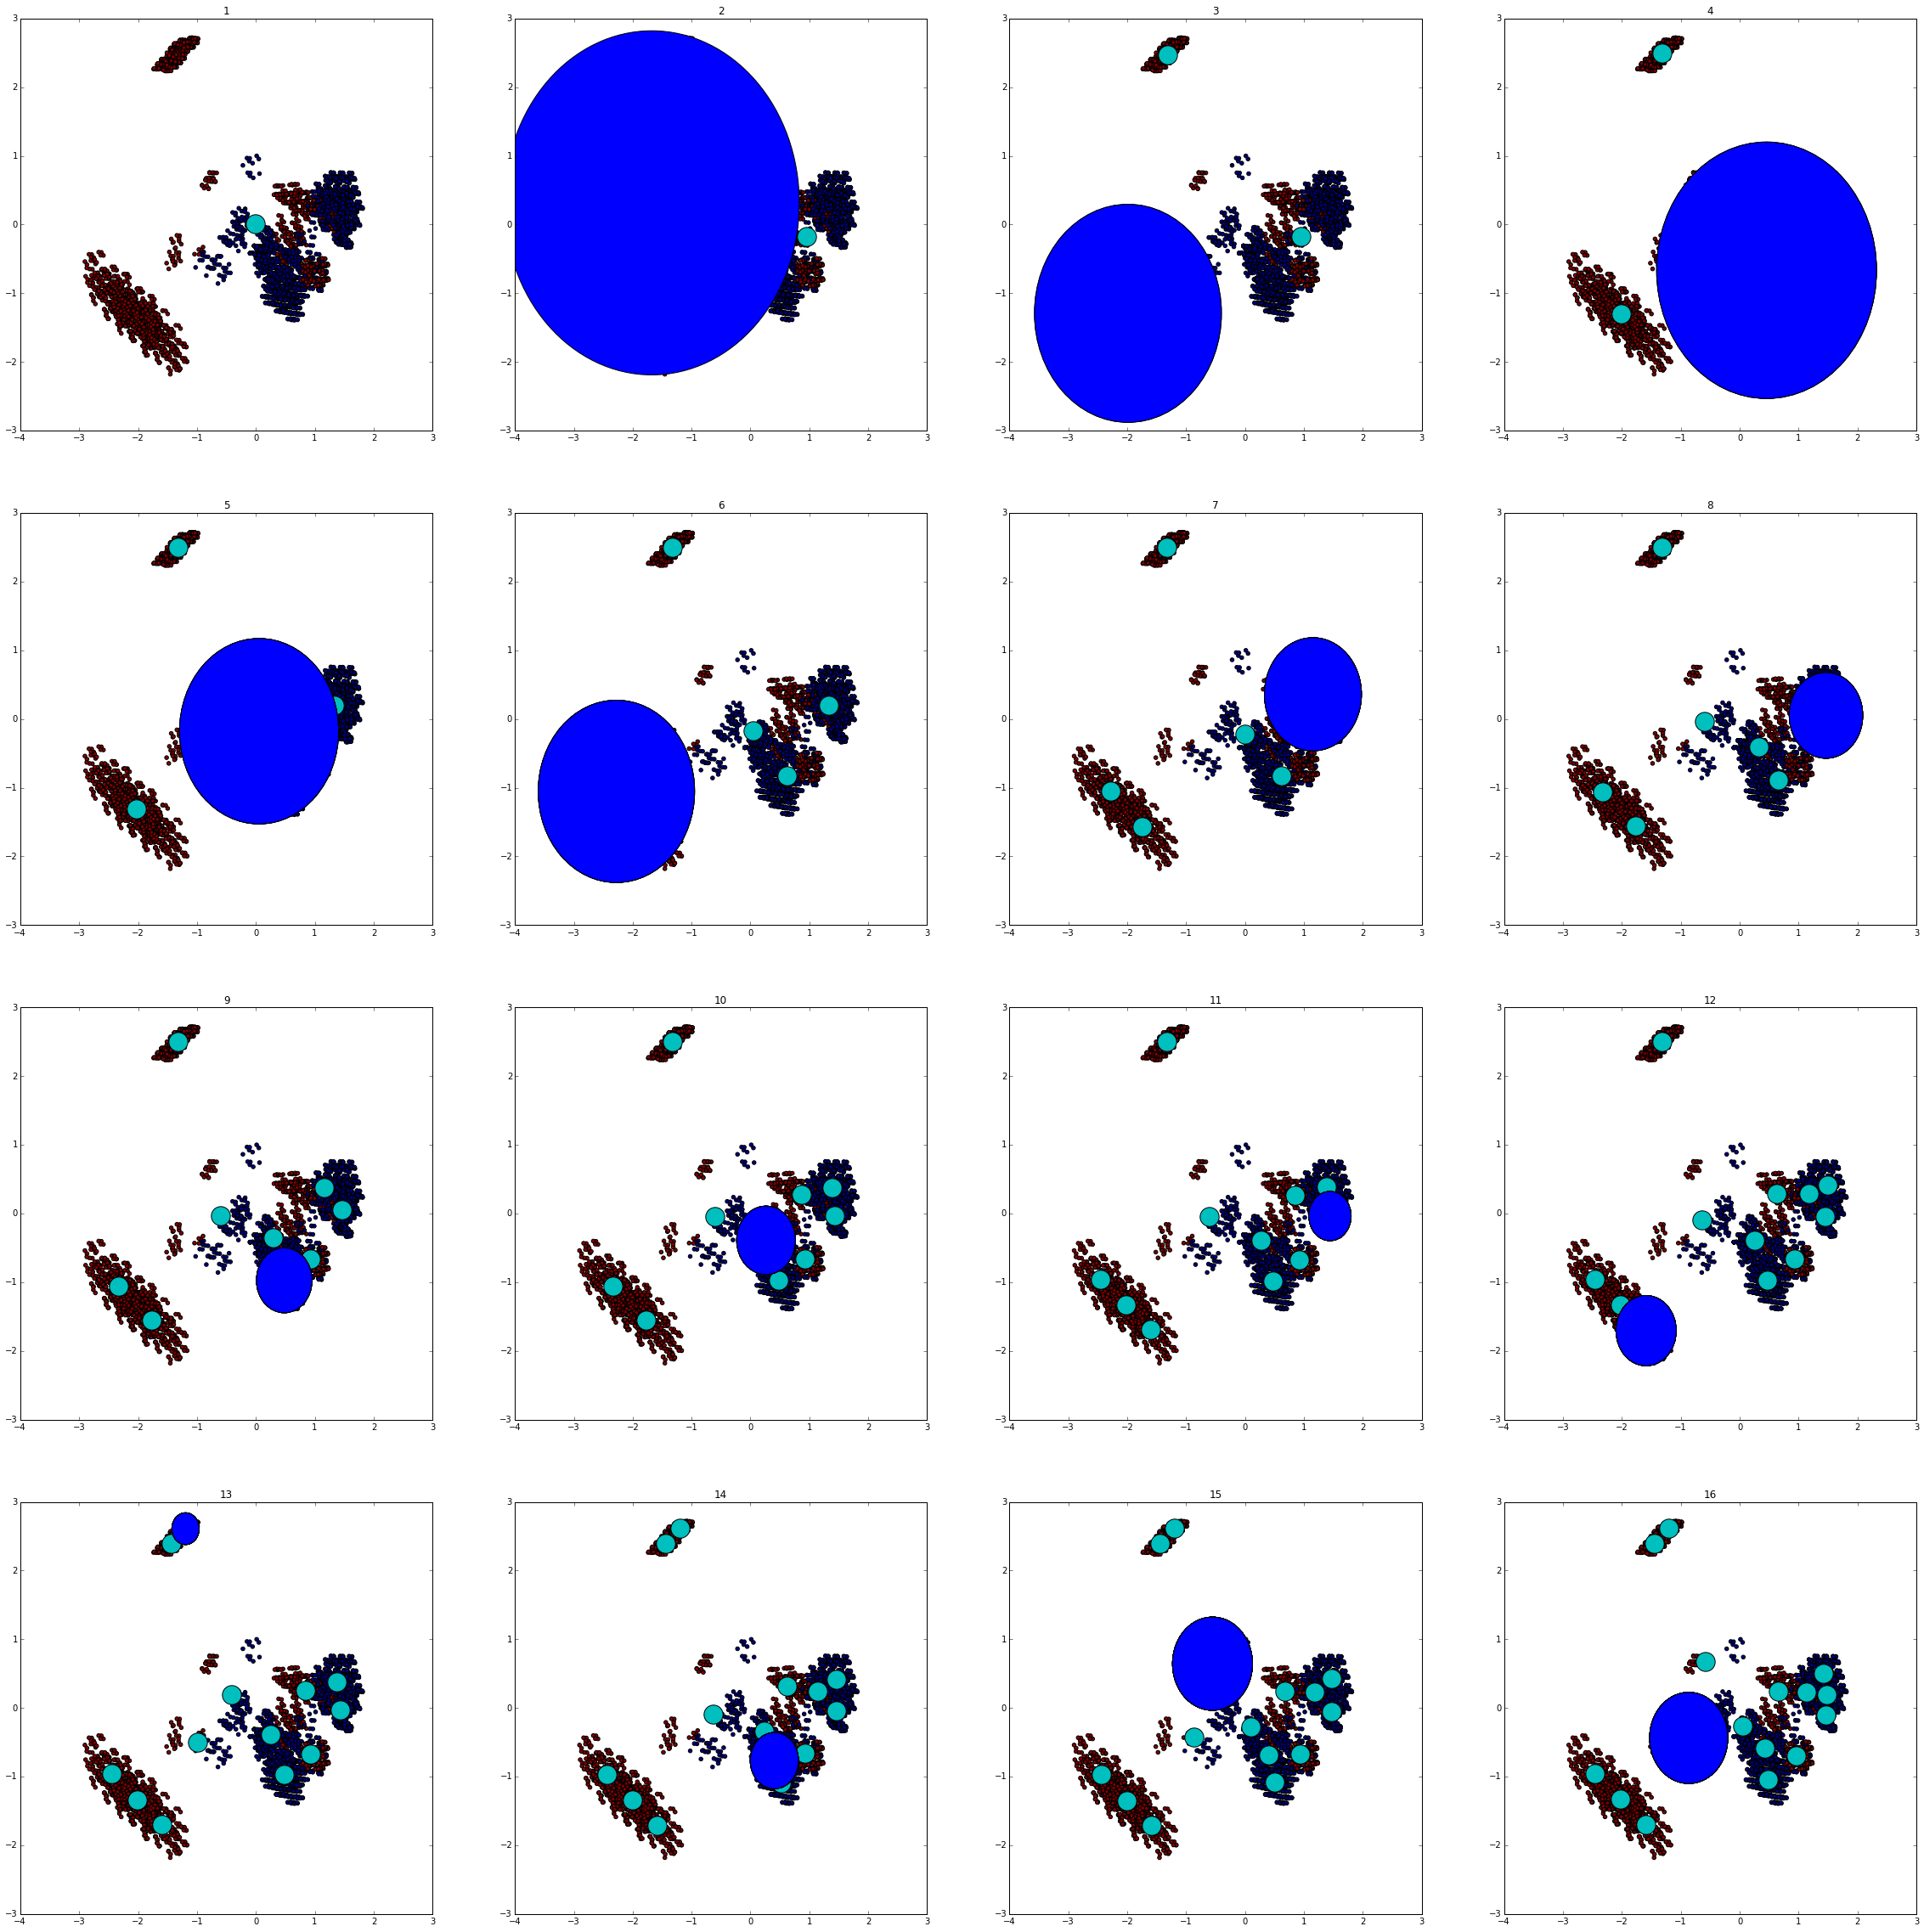

In [7]:
#def P3():
### STUDENT START ###

#plt.figure(figsize=(200,200))
f, axarr = plt.subplots(4,4, figsize = (40,40))
#f.figure(figsize=(30,30))

for i in range(16):
    
    kmeans_p3 = KMeans(n_clusters = i+1).fit(data_reduced)

    data_clustered_p3 = kmeans_p3.transform(data_reduced)

    #print data_clustered_p3
    #print kmeans_p3.cluster_centers_

    cluster_x = [x[0] for x in kmeans_p3.cluster_centers_]
    cluster_y = [x[1] for x in kmeans_p3.cluster_centers_]
    
    radii = []
    radius = 0
    for j in range(len(kmeans_p3.labels_)):
        if kmeans_p3.labels_[j] == i:
            rad_x = x_reduced[j]
            rad_y = y_reduced[j]
            cen_x = cluster_x[i]
            cen_y = cluster_y[i]
            this_radius = math.sqrt((rad_x - cen_x)**2 + (rad_y - cen_y)**2)
            if this_radius > radius:
                radius = this_radius
        radii.append(radius)
    print str(i)+": " + str(kmeans_p3.cluster_centers_[i]) + ", "+ str(radius)

    
    axarr[i/4,i%4].set_title(str(i+1))
    axarr[i/4,i%4].scatter(x_reduced, y_reduced, c = train_labels, label = "Poisonous")
    axarr[i/4,i%4].scatter(cluster_x, cluster_y, c = "c", s = 500)
    circles = []
    for k in range(i):
        circles.append(plt.Circle((kmeans_p3.cluster_centers_[i][0], kmeans_p3.cluster_centers_[i][1]), radius))
    for circle in circles:
        axarr[i/4,i%4].add_artist(circle)
    #axarr[i/4,i%4].scatter(cluster_x, cluster_y, c = "c", s = radii, facecolors = "none")


        #plt.legend(loc = "best")
#f.figure(figsize=(50,50))
plt.show()

### STUDENT END ###

#P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

In [8]:
pos_only_p4 = []
neg_only_p4 = []
for k in range(len(train_labels)):
    if (train_labels[k]==1):
        pos_only_p4.append(list(data_reduced[k]))
    else:
        neg_only_p4.append(list(data_reduced[k]))


7000
3198
[[ 1.05434454 -0.89426308]
 [ 1.44383045 -0.08008516]
 [ 1.54310134 -0.28842409]
 [ 1.18360334 -0.59804199]
 [ 0.63709298 -1.13351151]]
[[1.0543445357177907, -0.89426307594267196], [1.1836033404813666, -0.59804199248622514], [0.92105755906855247, -0.51390433898582788], [1.1394953392910014, -0.87919108778776778], [1.1897523078504137, -0.60220478450745918]]


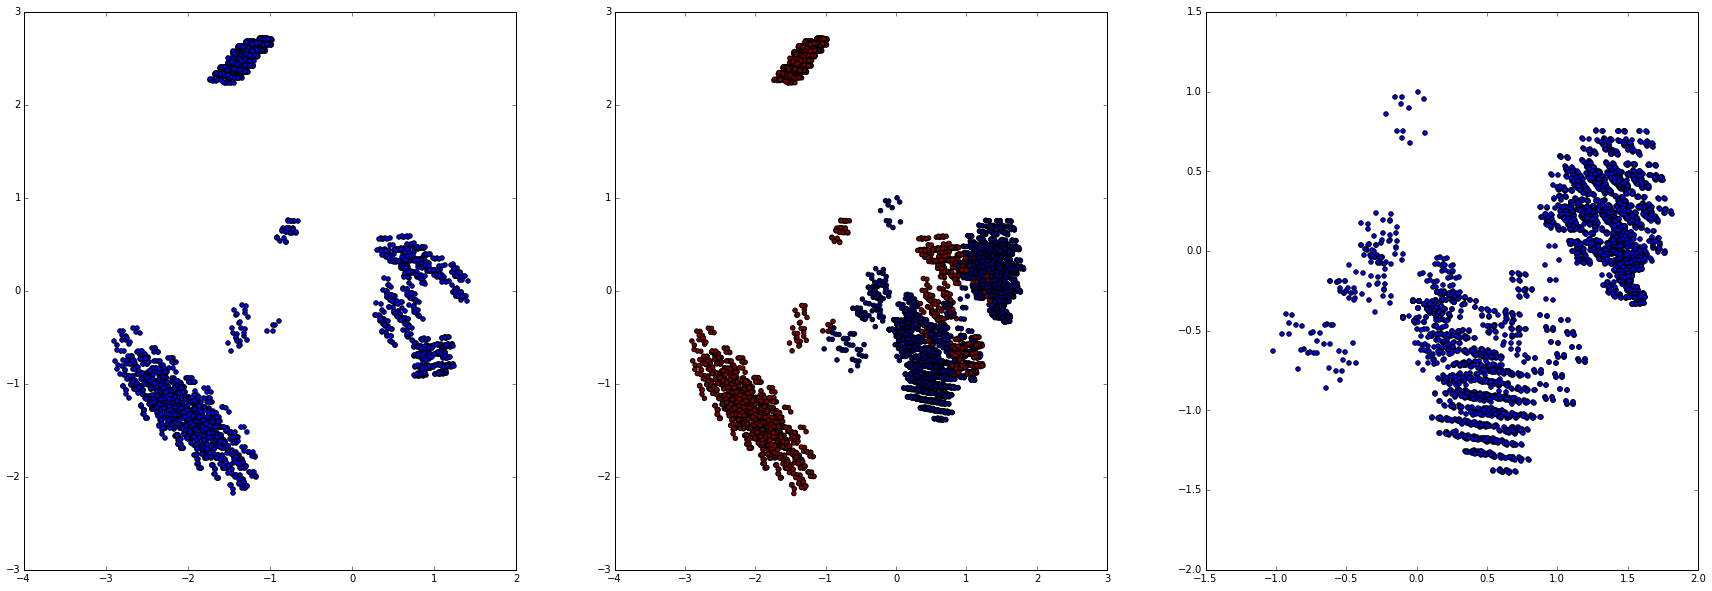

In [9]:
print len(data_reduced)
print len(pos_only_p4)
print data_reduced[:5]
print pos_only_p4[:5]

#plt.scatter([x[0] for x in data_reduced], [x[1] for x in data_reduced], c = train_labels)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.scatter([x[0] for x in pos_only_p4], [x[1] for x in pos_only_p4])

plt.subplot(1,3,2)
plt.scatter([x[0] for x in data_reduced], [x[1] for x in data_reduced], c = train_labels)

plt.subplot(1,3,3)
plt.scatter([x[0] for x in neg_only_p4], [x[1] for x in neg_only_p4])

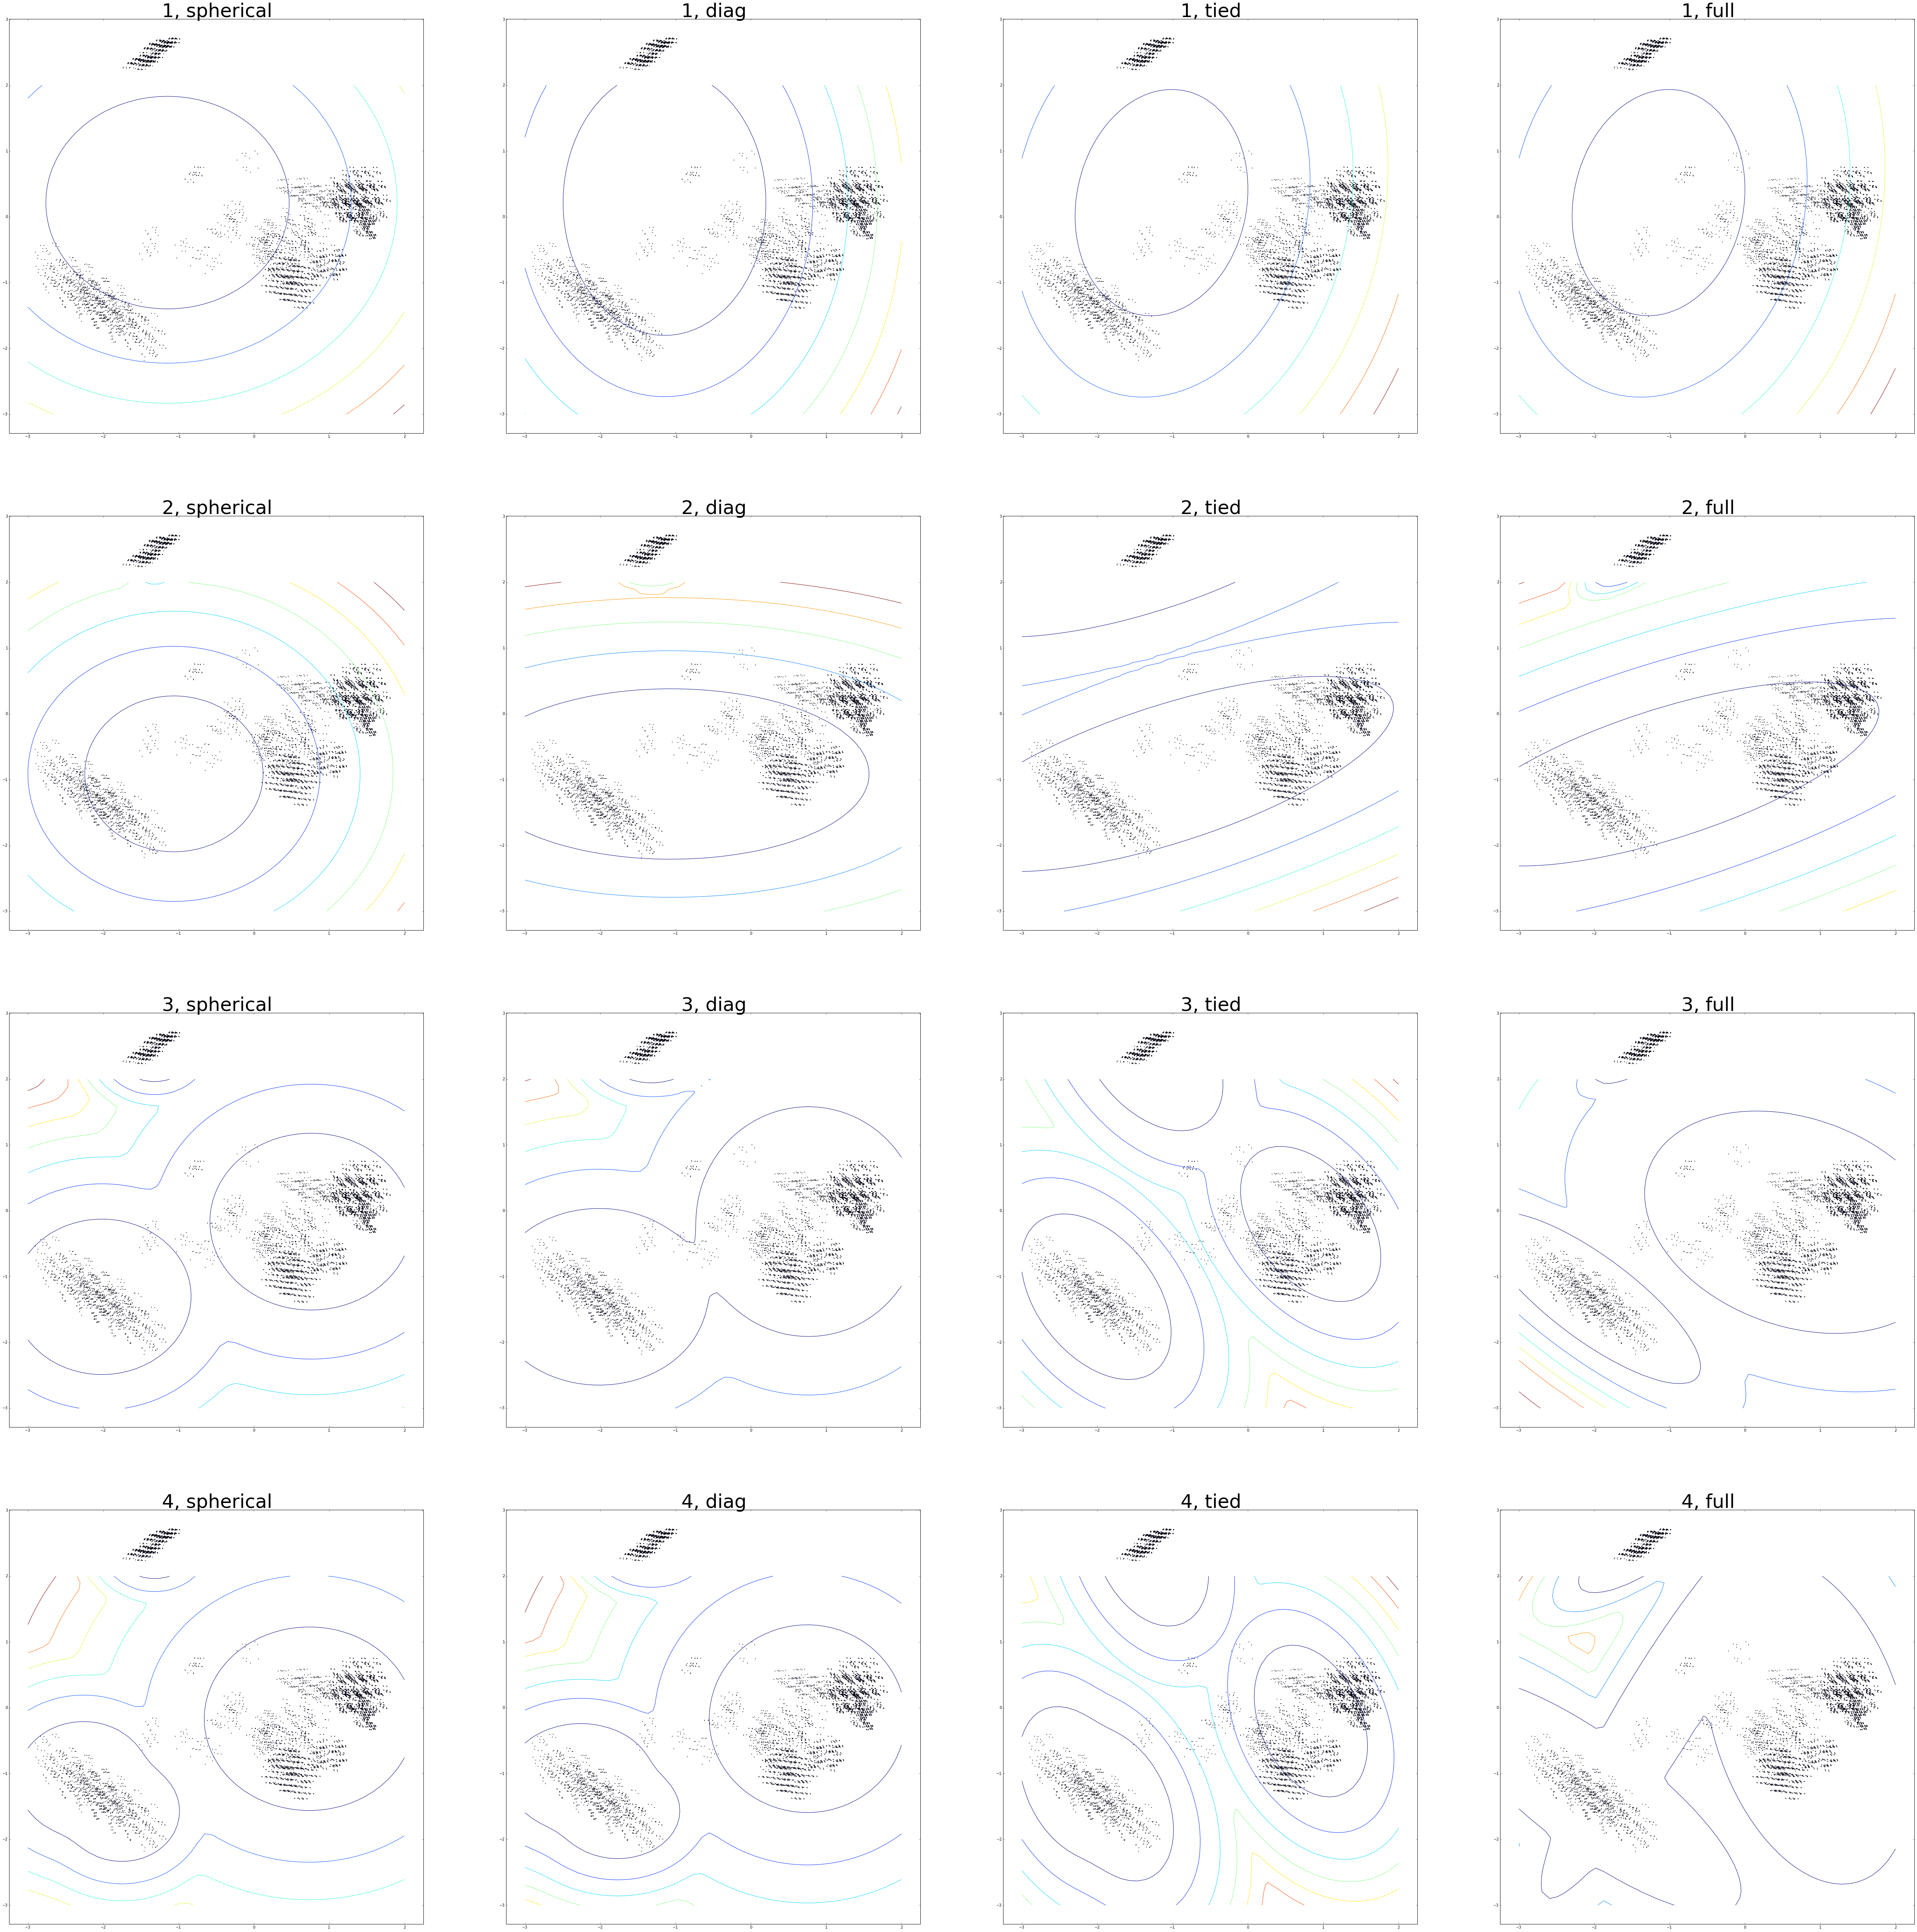

In [10]:
#def P4():
### STUDENT START ###

#plt.figure(figsize=(200,200))
#f, axarr = plt.subplots(4,4, figsize = (40,40))
f, axarr = plt.subplots(4,4, figsize = (90,90))
#f.figure(figsize=(30,30))

cmts = ["spherical","diag","tied","full"]
pos_only_p4 = []
for k in range(len(train_labels)):
    if (train_labels[k]==1):
        pos_only_p4.append(list(data_reduced[k]))


for i in range(4):
    for j in range(len(cmts)):
        
        GMM_p4 = GMM(i+1, covariance_type=cmts[j])

        GMM_p4.fit(pos_only_p4)

        x_p4 = np.linspace(-3.0, 2.0)
        y_p4 = np.linspace(-3.0, 2.0)
        X_p4, Y_p4 = np.meshgrid(x_p4, y_p4)
        XX_p4 = np.array([X_p4.ravel(), Y_p4.ravel()]).T
        Z_p4 = -GMM_p4.score_samples(XX_p4)[0]
        Z_p4 = Z_p4.reshape(X_p4.shape)
        
        axarr[i,j].set_title(str(i+1)+", "+cmts[j], fontdict={"fontsize": 50})
        axarr[i,j].contour(X_p4, Y_p4, Z_p4)
        #axarr[i/4,i%4].colorbar(CS_p4, shrink=0.8, extend='both')
        axarr[i,j].scatter(data_reduced[:, 0], data_reduced[:, 1], .8)


        #CS_p4 = plt.contour(X_p4, Y_p4, Z_p4)#, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.linspace(0, 5, 10))
        #CB_p4 = plt.colorbar(CS_p4, shrink=0.8, extend='both')
        #plt.

plt.axis('tight')
plt.show()
### STUDENT END ###

#P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [25]:
#def P5():
### STUDENT START ###

GMM_pos_p5 = GMM(4, covariance_type="full").fit(pos_only_p4)
GMM_neg_p5 = GMM(4, covariance_type="full").fit(neg_only_p4)

test_data_reduced = PCA(2).fit_transform(test_data)

pos_preds = GMM_pos_p5.score(test_data_reduced)
print "pos_preds:"
print pos_preds[:5]
neg_preds = GMM_neg_p5.score(test_data_reduced)
print "neg_preds:"
print neg_preds[:5]

print "Pos Pred\tNeg Pred\tPred\tActual"
for i in range(25):
    print str(pos_preds[i])+"\t"+str(neg_preds[i])+"\t"+str(int(pos_preds[i]>neg_preds[i]))+"\t"+str(test_labels[i])

correct_preds = 0

for i in range(len(test_data_reduced)):
    if (pos_preds[i] >= neg_preds[i] and train_labels[i] ==0):
        correct_preds += 1
    elif (pos_preds[i] <= neg_preds[i] and train_labels[i] ==1):
        correct_preds += 1
        
print "Accuracy: " + str(1.0*correct_preds/len(train_labels))



### STUDENT END ###

#P5()

pos_preds:
[-10.27446719 -15.44482603  -9.57937526  -3.68050469  -9.59469718]
neg_preds:
[-22.33645406 -27.57511841 -24.60570053 -12.22969872 -17.34303876]
Pos Pred	Neg Pred	Pred	Actual
-10.2744671869	-22.3364540561	1	0
-15.4448260304	-27.5751184098	1	0
-9.5793752574	-24.605700529	1	0
-3.68050469148	-12.2296987236	1	1
-9.59469717578	-17.3430387595	1	0
-17.2000448637	-30.8889094169	1	0
-12.4006423314	-21.2780762302	1	0
-9.49735713444	-15.7159740318	1	1
-13.9687003943	-29.4962407441	1	0
-12.8726852063	-20.7936050727	1	0
-14.3308945115	-25.7847314354	1	0
-17.8858274291	-20.7025226911	1	0
-18.0091764086	-32.4343290811	1	0
-9.34454066884	-24.8269559637	1	0
-11.3549651071	-26.1590427174	1	0
-12.1462785252	-23.0973198327	1	0
-11.6754012215	-15.6263380597	1	0
-15.7252849404	-25.0251364713	1	0
-17.0224319321	-30.9159953264	1	0
-10.9213809677	-23.1849427347	1	0
-16.5452507688	-34.4489898941	1	0
-9.89355810021	-14.3063798829	1	0
-11.8818899019	-19.9084668179	1	0
-22.7372825374	-22.3428607435	0	0


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [6]:
#def P6():
### STUDENT START ###

### STUDENT END ###

#P6()